# Data Processing

In [40]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import torchvision
import torch

import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torchvision.models as models

In [4]:
classes = ["chair" , "aeroplane" , "train" , "motorbike"]

In [5]:
annotation_directory_path = 'VOC2007/Annotations'
xml_files = os.listdir(annotation_directory_path)

for file in xml_files:
    xml_file_path = annotation_directory_path + '/' + file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Iterate through the XML elements and save cropped image   
    for object_elem in root.findall('.//object'):
        # Extract the class label
        class_label = object_elem.find('name').text
        if class_label.lower() in classes:
            # Extract the bounding box
            bndbox = object_elem.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Extract the image
            image_path = 'VOC2007/JPEGImages/' + file[:-4] + '.jpg'
            image = cv2.imread(image_path)
            
            # Crop the image
            cropped_image = image[ymin:ymax, xmin:xmax]
            
            # Save the image
            save_path = 'Dataset/train/' + class_label.lower() + '/' + file[:-4] + '.jpg'
            cv2.imwrite(save_path, cropped_image)
    

In [34]:
# transform = transforms.Compose([
#     transforms.Resize(target_size),  # Resize the image
#     transforms.ToTensor()  # Convert the image to a PyTorch tensor
# ])


transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(256),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width
    torchvision.transforms.RandomResizedCrop(256, scale=(0.84, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

In [42]:
batch_size = 32
num_classes = 4

In [36]:
train_ds  = torchvision.datasets.ImageFolder(
    "Dataset/train",
    transform=transform_train) 

In [37]:
train_iter = torch.utils.data.DataLoader( train_ds, batch_size, shuffle=True, drop_last=True)

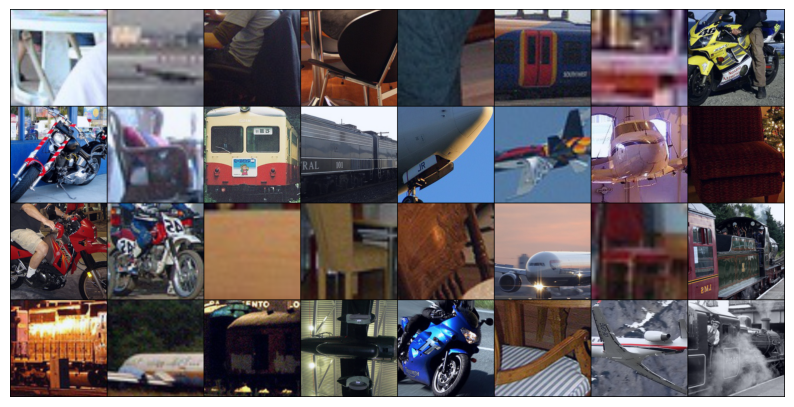

In [39]:
# Sample a batch from train_iter and visualise images and labels

for X, y in train_iter:
    # X is a batch of images

    # Use torchvision's make_grid to create a grid of images for easier visualization
    grid = vutils.make_grid(X, padding=2, normalize=True)

    # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
    grid = grid.permute(1, 2, 0).cpu().numpy()

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    # Break the loop to only plot one batch of images
    break  # Remove this line if you want to continue plotting more batches

In [47]:
import torch.nn as nn
import torch.optim as optim

In [43]:
# Load a pre-trained AlexNet model
model = models.alexnet(pretrained=True)

/Users/ninadkale/miniconda3/envs/bio/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ninadkale/miniconda3/envs/bio/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/ninadkale/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


In [48]:


# Modify the classifier to have 4 output classes instead of 1000 (the original number of classes)
model.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [50]:

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_iter:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_iter)}")


Epoch 1/10, Loss: 0.3394801346812306
Epoch 2/10, Loss: 0.19822335506721242
Epoch 3/10, Loss: 0.1400274143258973
Epoch 4/10, Loss: 0.09653788686888974
Epoch 5/10, Loss: 0.07223396212226008
Epoch 6/10, Loss: 0.05127819536662683
Epoch 7/10, Loss: 0.04251638359231193
Epoch 8/10, Loss: 0.03284539018257907
Epoch 9/10, Loss: 0.03266536948986624
Epoch 10/10, Loss: 0.04256531283849987
